In [43]:
import os
import numpy as np
import pandas as pd

data_ = {}

for filename in os.listdir("data/Top100Cryptos/"):
    path = os.path.join("data/Top100Cryptos/", filename)
    try:
        name = filename.split(".")[0]
        data_[name] = pd.read_csv(path)
    except:
        pass

num_data = []
for name in data_.keys():
    num_data.append(data_[name].shape[0])
name_list = np.array(list(data_.keys()))[np.argsort(num_data)[::-1]]
big_names = name_list[:10]

data = dict()
for name in big_names:
    data[name] = data_[name]

In [44]:
def convert_time(t):
    m = {
        'Jan' : "01",
        'Feb' : "02",
        'Mar' : "03",
        'Apr' : "04",
        'May' : "05",
        'Jun' : "06",
        'June' : "06",
        'Jul' : "07",
        'Aug' : "08",
        'Sep' : "09", 
        'Oct' : "10",
        'Nov' : "11",
        'Dec' : "12"
    }
    t_list = t.replace(",", "").split()
    t_list[0] = m[t_list[0]]
    return "-".join([t_list[2], t_list[0], t_list[1]])

In [75]:
from tensorforce.environments import Environment
from copy import deepcopy
import pandas as pd

class TradeEnvironment(Environment):
    """Environment only for close prices"""
    def __init__(self, data, start=None, end=None, add_cash=True):
        time_index = set()
        impute_data = {}
        data = deepcopy(data)
        for key, val in data.items():
            dates = val["Date"].values
            dates = [convert_time(d) for d in dates]
            impute_data[key] = dict(time_range=(dates[-1], dates[0]),
                                    impute_val=(val.iloc[-1], val.iloc[0]))
            data[key].index = dates
            time_index = time_index.union(set(dates))
        self.time_index = sorted(list(time_index))
        if add_cash:
            val = np.ones(len(self.time_index))
            cash_df = pd.DataFrame({"Open" : val,
                                    "High" : val,
                                    "Low" : val,
                                    "Close" : val,
                                    "Volume" : val},
                                   index=self.time_index)
            key = "Cash"
            data[key] = cash_df
            impute_data[key] = dict(time_range=(self.time_index[-1], self.time_index[0]),
                                    impute_val=(cash_df.iloc[-1], cash_df.iloc[0]))
        self.impute_data  = impute_data
        if start is None:
            self.start = self.time_index[0]
        else:
            self.start = min(start, self.time_index[0])
        if end is None:
            self.end = self.time_index[-1]
        else:
            self.end = max(end, self.time_index[-1])
        self.data = data
        self.symbols = list(data.keys())
        self.num_stocks = len(self.symbols)
        self.current_time = self.start
        self.current_step = 0
        # Use for calculate return
        self.prev_states = self._get_bar()

    def reset(self):
        """
        Reset environment and setup for new episode.
        Returns:
            initial state of resetted environment.
        """
        self.current_time = self.start
        self.cirrent_step = 0
        current_states = self._get_bar()
        states = np.array([current_states[symbol]["Close"] for symbol in self.symbols])
        return states

    def execute(self, actions):
        """
        Executes action, observes next state(s) and reward.
        Args:
            actions: Actions to execute.
        Returns:
            (Dict of) next state(s), boolean indicating terminal, and reward signal.
        """
        current_states = self._get_bar()
        returns = []
        for symbol in self.symbols:
            returns.append(current_states[symbol]["Close"] / self.prev_states[symbol]["Close"] - 1)
        # print("current_states", self.current_time)
        # Update status
        self.prev_states = deepcopy(current_states)
        self._update_time()
        states = np.array([current_states[symbol]["Close"] for symbol in self.symbols])
        terminal = False
        reward = np.sum(np.array(returns) * actions)
        return states, terminal, reward
        
            
    def _update_time(self):
        index = self.time_index.index(self.current_time)
        self.current_time = self.time_index[index + 1]
        self.current_step += 1
        
    def _get_bar(self):
        bar = {}
        for symbol in self.symbols:
            min_t = self.impute_data[symbol]["time_range"][0]
            max_t = self.impute_data[symbol]["time_range"][1]
            if (min_t <= self.current_time) and (max_t >= self.current_time):
                if self.current_time in self.data[symbol].index:
                    bar[symbol] = self.data[symbol].loc[self.current_time]
                else:
                    bar[symbol] = deepcopy(self.impute_bar[symbol])
            elif min_t > self.current_time:
                bar[symbol] = self.impute_data[symbol]["impute_val"][0]
            else:
                bar[symbol] = self.impute_data[symbol]["impute_val"][1]
        # Keep value for imputation
        self.impute_bar = deepcopy(bar)
        return bar

    @property
    def states(self):
        """
        Return the state space. Might include subdicts if multiple states are available simultaneously.
        Returns: dict of state properties (shape and type).
        """
        return {'shape': (self.num_stocks,), 'type': 'float'}

    @property
    def actions(self):
        """
        Return the action space. Might include subdicts if multiple actions are available simultaneously.
        Returns: dict of action properties (continuous, number of actions)
        """
        return {"shape": (self.num_stocks,), "min_value": 0., "max_value": 1., "type": "float"}

In [76]:
import numpy as np


def calc_stats(log_return, accumulated_pv, peak_pv):
    accumulated_pv *= np.exp(log_return)
    if peak_pv < accumulated_pv:
        peak_pv = accumulated_pv
    draw_down = (peak_pv - accumulated_pv) / peak_pv
    return_ = np.exp(log_return) - 1.
    return return_, accumulated_pv, peak_pv, draw_down

def calc_sharp_ratio(returns, bench_mark=0, eps=1e-6):
    var = np.var(returns)
    mean = np.mean(returns)
    return (mean - bench_mark) / (np.sqrt(var) + eps)

In [77]:
from __future__ import absolute_import
from __future__ import print_function
from __future__ import division

import time
from six.moves import xrange
from tensorforce.execution import Runner


class TradeRunner(Runner):
    """
    Simple runner for non-realtime single-process execution.
    """
    def run(
        self,
        timesteps=None,
        episodes=None,
        max_episode_timesteps=None,
        deterministic=False,
        episode_finished=None,
        init_pv=100.,
    ):
        """
        Runs the agent on the environment.

        Args:
            timesteps: Number of timesteps
            episodes: Number of episodes
            max_episode_timesteps: Max number of timesteps per episode
            deterministic: Deterministic flag
            episode_finished: Function handler taking a `Runner` argument and returning a boolean indicating
                whether to continue execution. For instance, useful for reporting intermediate performance or
                integrating termination conditions.
        """

        # Keep track of episode reward and episode length for statistics.
        self.start_time = time.time()

        self.agent.reset()

        self.episode = self.agent.episode
        if episodes is not None:
            episodes += self.agent.episode

        self.timestep = self.agent.timestep
        if timesteps is not None:
            timesteps += self.agent.timestep
            
        self.sp_list = []
        self.mmd_list = []
        self.pv_list = []
        self.accumulated_pvs_list = []
        self.draw_downs_list = []

        while True:
            episode_start_time = time.time()

            self.agent.reset()
            state = self.environment.reset()
            accumulated_pv = init_pv
            peak_pv = init_pv
            self.accumulated_pvs = [accumulated_pv]
            draw_downs = [0.]
            returns = [0.]
            self.episode_timestep = 0

            while True:
                action = self.agent.act(states=state, deterministic=deterministic)
                log_return = 0
                for repeat in xrange(self.repeat_actions):
                    state, terminal, step_reward = self.environment.execute(actions=action)
                    log_return += np.log(1. + step_reward)
                    if terminal:
                        break

                if max_episode_timesteps is not None and self.episode_timestep >= max_episode_timesteps:
                    terminal = True

                self.agent.observe(terminal=terminal, reward=log_return)

                self.episode_timestep += 1
                self.timestep += 1
                return_, accumulated_pv, peak_pv, draw_down = calc_stats(log_return, accumulated_pv, peak_pv)
                returns.append(return_)
                self.accumulated_pvs.append(accumulated_pv)
                draw_downs.append(draw_down)
                
                if terminal or self.agent.should_stop():  # TODO: should_stop also termina?
                    break
                    
            time_passed = time.time() - episode_start_time

            self.pv_list.append(self.accumulated_pvs[-1])
            self.mmd_list.append(np.max(draw_downs))
            self.sp_list.append(calc_sharp_ratio(returns))
            self.accumulated_pvs_list.append(self.accumulated_pvs)
            self.draw_downs_list.append(draw_downs)
            
            self.episode_timesteps.append(self.episode_timestep)
            self.episode_times.append(time_passed)

            self.episode += 1

            if episode_finished and not episode_finished(self) or \
                    (episodes is not None and self.agent.episode >= episodes) or \
                    (timesteps is not None and self.agent.timestep >= timesteps) or \
                    self.agent.should_stop():
                # agent.episode / agent.timestep are globally updated
                break

        self.agent.close()
        self.environment.close()

In [90]:
from tensorforce.agents import PPOAgent
from tensorforce.execution import Runner

env = TradeEnvironment(data)
num_stocks = env.num_stocks
# Create a Proximal Policy Optimization agent
agent = PPOAgent(
    states_spec=dict(type='float', shape=(num_stocks,)),
    actions_spec=dict(type='float', shape=(num_stocks,)),
    network_spec=[
        dict(type="flatten"),
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    distributions_spec=dict(action=dict(type="dirichlet",
                                        alphas=np.zeros(num_stocks),
                                        min_value=0.,
                                        max_value=1.)),
    batch_size=10,
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-4
    )
)

# Poll new state from client
state = env.reset()

runner = TradeRunner(
        agent=agent,
        environment=env,
        repeat_actions=1
    )

def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})".format(ep=r.episode, ts=r.episode_timestep,
                                                                                 reward=r.accumulated_pvs[-1]))
    return True


# Start learning
runner.run(episodes=500, max_episode_timesteps=200, episode_finished=episode_finished)

Finished episode 1 after 201 timesteps (reward: 123.2162936229729)
Finished episode 2 after 201 timesteps (reward: 168.9315061248446)
Finished episode 3 after 201 timesteps (reward: 75.19972188695223)
Finished episode 4 after 201 timesteps (reward: 119.30127310507494)
Finished episode 5 after 201 timesteps (reward: 111.12543626299829)
Finished episode 6 after 201 timesteps (reward: 124.0993520172236)
Finished episode 7 after 201 timesteps (reward: 158.3964552070213)
Finished episode 8 after 201 timesteps (reward: 159.02973401390656)
Finished episode 9 after 201 timesteps (reward: 107.98572828625132)
Finished episode 10 after 201 timesteps (reward: 102.71853604542662)
Finished episode 11 after 201 timesteps (reward: 118.52963250756463)
Finished episode 12 after 201 timesteps (reward: 149.50535044546365)
Finished episode 13 after 201 timesteps (reward: 110.32936822368883)
Finished episode 14 after 201 timesteps (reward: 140.90017079319563)
Finished episode 15 after 201 timesteps (reward:

Finished episode 121 after 201 timesteps (reward: 154.7218415312743)
Finished episode 122 after 201 timesteps (reward: 110.86422120279548)
Finished episode 123 after 201 timesteps (reward: 127.72186681134136)
Finished episode 124 after 201 timesteps (reward: 109.11176862039504)
Finished episode 125 after 201 timesteps (reward: 120.92365877335929)
Finished episode 126 after 201 timesteps (reward: 149.75359123690924)
Finished episode 127 after 201 timesteps (reward: 106.87569365834428)
Finished episode 128 after 201 timesteps (reward: 119.58492611066188)
Finished episode 129 after 201 timesteps (reward: 77.84606750649006)
Finished episode 130 after 201 timesteps (reward: 152.76018538637547)
Finished episode 131 after 201 timesteps (reward: 86.26018713228049)
Finished episode 132 after 201 timesteps (reward: 96.51902617122732)
Finished episode 133 after 201 timesteps (reward: 86.50106888730463)
Finished episode 134 after 201 timesteps (reward: 155.93018448512265)
Finished episode 135 afte

Finished episode 239 after 201 timesteps (reward: 114.40075168494174)
Finished episode 240 after 201 timesteps (reward: 122.77306948458325)
Finished episode 241 after 201 timesteps (reward: 137.58403822495362)
Finished episode 242 after 201 timesteps (reward: 126.49806020628058)
Finished episode 243 after 201 timesteps (reward: 166.05486694292375)
Finished episode 244 after 201 timesteps (reward: 139.73987625529682)
Finished episode 245 after 201 timesteps (reward: 134.6638286436461)
Finished episode 246 after 201 timesteps (reward: 113.18509921610134)
Finished episode 247 after 201 timesteps (reward: 160.01353980575232)
Finished episode 248 after 201 timesteps (reward: 110.45102882131445)
Finished episode 249 after 201 timesteps (reward: 100.45118003686422)
Finished episode 250 after 201 timesteps (reward: 124.55741068903147)
Finished episode 251 after 201 timesteps (reward: 171.17273396699238)
Finished episode 252 after 201 timesteps (reward: 159.04671141882292)
Finished episode 253 

Finished episode 357 after 201 timesteps (reward: 116.93298041582372)
Finished episode 358 after 201 timesteps (reward: 115.80273696499046)
Finished episode 359 after 201 timesteps (reward: 104.08217844437311)
Finished episode 360 after 201 timesteps (reward: 126.88502482220584)
Finished episode 361 after 201 timesteps (reward: 140.39308778887843)
Finished episode 362 after 201 timesteps (reward: 122.77217772053616)
Finished episode 363 after 201 timesteps (reward: 125.21118010684134)
Finished episode 364 after 201 timesteps (reward: 107.19594936361091)
Finished episode 365 after 201 timesteps (reward: 149.27245678330559)
Finished episode 366 after 201 timesteps (reward: 81.89504692419112)
Finished episode 367 after 201 timesteps (reward: 139.14346855569445)
Finished episode 368 after 201 timesteps (reward: 128.1617954423135)
Finished episode 369 after 201 timesteps (reward: 122.86968315689731)
Finished episode 370 after 201 timesteps (reward: 132.22457833735186)
Finished episode 371 a

Finished episode 475 after 201 timesteps (reward: 176.54712097700354)
Finished episode 476 after 201 timesteps (reward: 86.28206994836042)
Finished episode 477 after 201 timesteps (reward: 114.337631456259)
Finished episode 478 after 201 timesteps (reward: 122.86159919837327)
Finished episode 479 after 201 timesteps (reward: 174.17475463260524)
Finished episode 480 after 201 timesteps (reward: 114.31384018618736)
Finished episode 481 after 201 timesteps (reward: 166.6827841320274)
Finished episode 482 after 201 timesteps (reward: 174.05678279462336)
Finished episode 483 after 201 timesteps (reward: 114.98023802345169)
Finished episode 484 after 201 timesteps (reward: 136.40223345896507)
Finished episode 485 after 201 timesteps (reward: 157.5116590775483)
Finished episode 486 after 201 timesteps (reward: 92.25498843206977)
Finished episode 487 after 201 timesteps (reward: 175.363323722127)
Finished episode 488 after 201 timesteps (reward: 85.48008321664796)
Finished episode 489 after 20

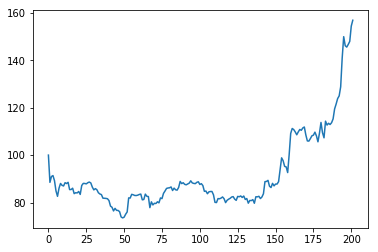

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(runner.accumulated_pvs_list[-12])

In [ ]:
from tensorforce.core.memories import Replay


class SeqReplay(Replay):
    """
    Replay memory to store observations and sample mini batches for training from.
    """

    def __init__(self, states_spec, actions_spec, capacity, random_sampling=True, beta=0.1):
        self.beta = beta
        super(SeqReplay, self).__init__(states_spec, actions_spec, capacity, random_sampling)
        self.capacity = capacity
        state_shape = list(state["shape"])[1:]
        self.length = state["shape"][0]
        self.states = {name: np.zeros((capacity,) + tuple(state_shape), dtype=util.np_dtype(state['type'])) for name, state in states_spec.items()}
        self.internals = None
        self.actions = {name: np.zeros((capacity,) + tuple(action['shape']), dtype=util.np_dtype(action['type'])) for name, action in actions_spec.items()}
        self.terminal = np.zeros((capacity,), dtype=util.np_dtype('bool'))
        self.reward = np.zeros((capacity,), dtype=util.np_dtype('float'))

        self.size = 0
        self.index = 0
        self.random_sampling = random_sampling
        
    def _get_seq_index(self, X, index):
        X_seq = []
        for i in index:
            idx = np.arange(i - self.length + 1, i + 1) % self.size
            X_seq.append(X.take(idx, axis=0))
        return np.array(X_seq)
    
    def _sample_index(self, shape, maximum, length, start_index):
        assert maximum > length
        num_cand = maximum - length + 1
        samples = (np.random.geometric(self.beta, shape) - 1) % num_cand
        samples = (start_index - samples) % self.capacity
        return samples

    def get_batch(self, batch_size, next_states=False, keep_terminal_states=True):
        """
        Samples a batch of the specified size by selecting a random start/end point and returning
        the contained sequence or random indices depending on the field 'random_sampling'.
        
        Args:
            batch_size: The batch size
            next_states: A boolean flag indicating whether 'next_states' values should be included
            keep_terminal_states: A boolean flag indicating whether to keep terminal states when
                `next_states` are requested. In this case, the next state is not from the same episode
                and should probably not be used to learn a model of the environment. However, if the
                environment produces sparse rewards (i.e. only one reward at the end of the episode) we
                cannot exclude terminal states, as otherwise there would never be a reward to learn from.
        Returns: A dict containing states, actions, rewards, terminals, internal states (and next states)
        """
        if self.random_sampling:
            if next_states:
                indices = self._sample_index(batch_size, self.size - 1, self.length, self.index - 1)
                terminal = self.terminal.take(indices)
                if not keep_terminal_states:
                    while np.any(terminal):
                        alternative = np.random.randint(self.size - 1, size=batch_size)
                        indices = np.where(terminal, alternative, indices)
                        terminal = self.terminal.take(indices)
            else:
                indices = self._sample_index(batch_size, self.size - 1, self.length, self.index - 1)

            states = {name: self._get_seq_index(state, indices) for name, state in self.states.items()}
            internals = [self._get_seq_index(internal, indices) for internal in self.internals]
            actions = {name: self._get_seq_index(action, indices) for name, action in self.actions.items()}
            terminal = self._get_seq_index(self.terminal, indices)
            reward = self._get_seq_index(self.reward, indices)
            if next_states:
                indices = (indices + 1) % self.capacity
                next_states = {name: self._get_seq_index(state, indices) for name, state in self.states.items()}
                next_internals = [self._get_seq_index(internal, indices) for internal in self.internals]

        else:
            raise NotImplementedError()
            
        batch = dict(states=states, internals=internals, actions=actions, terminal=terminal, reward=reward)
        if next_states:
            batch['next_states'] = next_states
            batch['next_internals'] = next_internals
        return batch

    def update_batch(self, loss_per_instance):
        pass

    def set_memory(self, states, internals, actions, terminal, reward):
        """
        Convenience function to set whole batches as memory content to bypass
        calling the insert function for every single experience.
        Args:
            states:
            internals:
            actions:
            terminal:
            reward:
        Returns:
        """
        self.size = len(terminal)

        if len(terminal) == self.capacity:
            # Assign directly if capacity matches size.
            for name, state in states.items():
                self.states[name] = np.asarray(state)
            self.internals = [np.asarray(internal) for internal in internals]
            for name, action in actions.items():
                self.actions[name] = np.asarray(action)
            self.terminal = np.asarray(terminal)
            self.reward = np.asarray(reward)
            # Filled capacity to point of index wrap
            self.index = 0

        else:
            # Otherwise partial assignment.
            if self.internals is None and internals is not None:
                self.internals = [np.zeros((self.capacity,) + internal.shape, internal.dtype) for internal
                                  in internals]

            for name, state in states.items():
                self.states[name][:len(state)] = state
            for n, internal in enumerate(internals):
                self.internals[n][:len(internal)] = internal
            for name, action in actions.items():
                self.actions[name][:len(action)] = action
            self.terminal[:len(terminal)] = terminal
            self.reward[:len(reward)] = reward
            self.index = len(terminal)

In [ ]:
import numpy as np
import tensorflow as tf

from tensorforce import util, TensorForceError
from tensorforce.models import DistributionModel
from tensorforce.core.networks import Network
from tensorforce.core.optimizers import Synchronization


class DDPGModel(DistributionModel):
    """
    Q-value model.
    """
    def tf_actions_and_internals(self, states, internals, update, deterministic):
        """You have to implement to have connections between actions and input"""
        embedding, internals = self.network.apply(x=states,
                                                  internals=internals,
                                                  update=update,
                                                  return_internals=True)
        actions = dict()
        for name, distribution in self.distributions.items():
            distr_params = distribution.parameterize(x=embedding)
            actions[name] = distribution.sample(distr_params=distr_params, deterministic=deterministic)
        return actions, internals
    
    def tf_discounted_cumulative_reward(self, terminal, reward, discount, final_reward=0.0):
        """
        Creates the TensorFlow operations for calculating the discounted cumulative rewards
        for a given sequence of rewards.
        Args:
            terminal: Terminal boolean tensor.
            reward: Reward tensor.
            discount: Discount factor.
            final_reward: Last reward value in the sequence.
        Returns:
            Discounted cumulative reward tensor.
        """

        # TODO: n-step cumulative reward (particularly for envs without terminal)

        def cumulate(cumulative, reward_and_terminal):
            rew, term = reward_and_terminal
            return tf.where(
                condition=term,
                x=rew,
                y=(rew + cumulative * discount)
            )

        # Reverse since reward cumulation is calculated right-to-left, but tf.scan only works left-to-right
        reward = tf.reverse(tensor=reward, axis=(0,))
        terminal = tf.reverse(tensor=terminal, axis=(0,))

        reward = tf.scan(fn=cumulate, elems=(reward, terminal), initializer=final_reward)

        return tf.reverse(tensor=reward, axis=(0,))

    def __init__(
        self,
        states_spec,
        actions_spec,
        network_spec,
        device,
        session_config,
        scope,
        saver_spec,
        summary_spec,
        distributed_spec,
        optimizer,
        discount,
        variable_noise,
        states_preprocessing_spec,
        explorations_spec,
        reward_preprocessing_spec,
        distributions_spec,
        entropy_regularization,
        target_sync_frequency,
        target_update_weight,
        double_q_model,
        huber_loss,
        # TEMP: Random sampling fix
        random_sampling_fix
    ):
        self.target_sync_frequency = target_sync_frequency
        self.target_update_weight = target_update_weight

        self.double_q_model = double_q_model

        assert huber_loss is None or huber_loss > 0.0
        self.huber_loss = huber_loss

        # TEMP: Random sampling fix
        self.random_sampling_fix = random_sampling_fix

        super(QModel, self).__init__(
            states_spec=states_spec,
            actions_spec=actions_spec,
            network_spec=network_spec,
            device=device,
            session_config=session_config,
            scope=scope,
            saver_spec=saver_spec,
            summary_spec=summary_spec,
            distributed_spec=distributed_spec,
            optimizer=optimizer,
            discount=discount,
            variable_noise=variable_noise,
            states_preprocessing_spec=states_preprocessing_spec,
            explorations_spec=explorations_spec,
            reward_preprocessing_spec=reward_preprocessing_spec,
            distributions_spec=distributions_spec,
            entropy_regularization=entropy_regularization,
        )

    def initialize(self, custom_getter):
        super(QModel, self).initialize(custom_getter)

        # TEMP: Random sampling fix
        if self.random_sampling_fix:
            self.next_states_input = dict()
            for name, state in self.states_spec.items():
                self.next_states_input[name] = tf.placeholder(
                    dtype=util.tf_dtype(state['type']),
                    shape=(None,) + tuple(state['shape']),
                    name=('next-' + name)
                )

        # Target network
        self.target_network = Network.from_spec(
            spec=self.network_spec,
            kwargs=dict(scope='target', summary_labels=self.summary_labels)
        )

        # Target network optimizer
        self.target_optimizer = Synchronization(
            sync_frequency=self.target_sync_frequency,
            update_weight=self.target_update_weight
        )

        # Target network distributions
        self.target_distributions = self.create_distributions()

    def tf_q_value(self, embedding, distr_params, action, name):
        # Mainly for NAF.
        return self.distributions[name].state_action_value(distr_params=distr_params, action=action)

    def tf_q_delta(self, q_value, next_q_value, terminal, reward):
        """
        Creates the deltas (or advantage) of the Q values.
        :return: A list of deltas per action
        """
        for _ in range(util.rank(q_value) - 1):
            terminal = tf.expand_dims(input=terminal, axis=1)
            reward = tf.expand_dims(input=reward, axis=1)

        multiples = (1,) + util.shape(q_value)[1:]
        terminal = tf.tile(input=terminal, multiples=multiples)
        reward = tf.tile(input=reward, multiples=multiples)

        zeros = tf.zeros_like(tensor=next_q_value)
        next_q_value = tf.where(condition=terminal, x=zeros, y=(self.discount * next_q_value))

        return reward + next_q_value - q_value  # tf.stop_gradient(q_target)

    def tf_loss_per_instance(self, states, internals, actions, terminal, reward, update):
        # TEMP: Random sampling fix
        if self.random_sampling_fix:
            next_states = {name: tf.identity(input=state) for name, state in self.next_states_input.items()}
            next_states = self.fn_preprocess_states(states=next_states)
            next_states = {name: tf.stop_gradient(input=state) for name, state in next_states.items()}

            embedding, next_internals = self.network.apply(
                x=states,
                internals=internals,
                update=update,
                return_internals=True
            )

            # Both networks can use the same internals, could that be a problem?
            # Otherwise need to handle internals indices correctly everywhere
            target_embedding = self.target_network.apply(
                x=next_states,
                internals=next_internals,
                update=update
            )

        else:
            embedding = self.network.apply(
                x={name: state[:-1] for name, state in states.items()},
                internals=[internal[:-1] for internal in internals],
                update=update
            )

            # Both networks can use the same internals, could that be a problem?
            # Otherwise need to handle internals indices correctly everywhere
            target_embedding = self.target_network.apply(
                x={name: state[1:] for name, state in states.items()},
                internals=[internal[1:] for internal in internals],
                update=update
            )

            actions = {name: action[:-1] for name, action in actions.items()}
            terminal = terminal[:-1]
            reward = reward[:-1]

        deltas = list()
        for name, distribution in self.distributions.items():
            target_distribution = self.target_distributions[name]

            distr_params = distribution.parameterize(x=embedding)
            target_distr_params = target_distribution.parameterize(x=target_embedding)

            q_value = self.tf_q_value(embedding=embedding, distr_params=distr_params, action=actions[name], name=name)

            if self.double_q_model:
                action_taken = distribution.sample(distr_params=distr_params, deterministic=True)
            else:
                action_taken = target_distribution.sample(distr_params=target_distr_params, deterministic=True)

            next_q_value = target_distribution.state_action_value(distr_params=target_distr_params, action=action_taken)

            delta = self.tf_q_delta(q_value=q_value, next_q_value=next_q_value, terminal=terminal, reward=reward)

            collapsed_size = util.prod(util.shape(delta)[1:])
            delta = tf.reshape(tensor=delta, shape=(-1, collapsed_size))

            deltas.append(delta)

        # Surrogate loss as the mean squared error between actual observed rewards and expected rewards
        loss_per_instance = tf.reduce_mean(input_tensor=tf.concat(values=deltas, axis=1), axis=1)

        # Optional Huber loss
        if self.huber_loss is not None and self.huber_loss > 0.0:
            return tf.where(
                condition=(tf.abs(x=loss_per_instance) <= self.huber_loss),
                x=(0.5 * tf.square(x=loss_per_instance)),
                y=(self.huber_loss * (tf.abs(x=loss_per_instance) - 0.5 * self.huber_loss))
            )
        else:
            return tf.square(x=loss_per_instance)

    def tf_optimization(self, states, internals, actions, terminal, reward, update):
        optimization = super(QModel, self).tf_optimization(
            states=states,
            internals=internals,
            actions=actions,
            terminal=terminal,
            reward=reward,
            update=update
        )

        network_distributions_variables = self.get_distributions_variables(self.distributions)
        target_distributions_variables = self.get_distributions_variables(self.target_distributions)

        target_optimization = self.target_optimizer.minimize(
            time=self.timestep,
            variables=self.target_network.get_variables() + target_distributions_variables,
            source_variables=self.network.get_variables() + network_distributions_variables
        )

        return tf.group(optimization, target_optimization)

    def get_variables(self, include_non_trainable=False):
        model_variables = super(QModel, self).get_variables(include_non_trainable=include_non_trainable)

        if include_non_trainable:
            # Target network and optimizer variables only included if 'include_non_trainable' set
            target_variables = self.target_network.get_variables(include_non_trainable=include_non_trainable)
            target_distributions_variables = self.get_distributions_variables(self.target_distributions)
            target_optimizer_variables = self.target_optimizer.get_variables()

            return model_variables + target_variables + target_optimizer_variables + target_distributions_variables

        else:
            return model_variables

In [ ]:
from tensorforce import TensorForceError
from tensorforce.agents import MemoryAgent
from tensorforce.models import QModel


class DDPGAgent(MemoryAgent):
    """
    Deep-Q-Network agent (DQN). The piece de resistance of deep reinforcement learning as described by
    [Minh et al. (2015)](http://www.nature.com/nature/journal/v518/n7540/full/nature14236.html). Includes
    an option for double-DQN (DDQN; [van Hasselt et al., 2015](https://arxiv.org/abs/1509.06461))
    DQN chooses from one of a number of discrete actions by taking the maximum Q-value
    from the value function with one output neuron per available action. DQN uses a replay memory for experience
    playback.
    """

    def __init__(
        self,
        states_spec,
        actions_spec,
        network_spec,
        device=None,
        session_config=None,
        scope='dqn',
        saver_spec=None,
        summary_spec=None,
        distributed_spec=None,
        optimizer=None,
        discount=0.99,
        variable_noise=None,
        states_preprocessing_spec=None,
        explorations_spec=None,
        reward_preprocessing_spec=None,
        distributions_spec=None,
        entropy_regularization=None,
        target_sync_frequency=10000,
        target_update_weight=1.0,
        double_q_model=False,
        huber_loss=None,
        batched_observe=None,
        batch_size=32,
        memory=None,
        first_update=10000,
        update_frequency=4,
        repeat_update=1
    ):
        """
        Creates a Deep-Q agent.
        Args:
            states_spec: Dict containing at least one state definition. In the case of a single state,
               keys `shape` and `type` are necessary. For multiple states, pass a dict of dicts where each state
               is a dict itself with a unique name as its key.
            actions_spec: Dict containing at least one action definition. Actions have types and either `num_actions`
                for discrete actions or a `shape` for continuous actions. Consult documentation and tests for more.
            network_spec: List of layers specifying a neural network via layer types, sizes and optional arguments
                such as activation or regularisation. Full examples are in the examples/configs folder.
            device: Device string specifying model device.
            session_config: optional tf.ConfigProto with additional desired session configurations
            scope: TensorFlow scope, defaults to agent name (e.g. `dqn`).
            saver_spec: Dict specifying automated saving. Use `directory` to specify where checkpoints are saved. Use
                either `seconds` or `steps` to specify how often the model should be saved. The `load` flag specifies
                if a model is initially loaded (set to True) from a file `file`.
            summary_spec: Dict specifying summaries for TensorBoard. Requires a 'directory' to store summaries, `steps`
                or `seconds` to specify how often to save summaries, and a list of `labels` to indicate which values
                to export, e.g. `losses`, `variables`. Consult neural network class and model for all available labels.
            distributed_spec: Dict specifying distributed functionality. Use `parameter_server` and `replica_model`
                Boolean flags to indicate workers and parameter servers. Use a `cluster_spec` key to pass a TensorFlow
                cluster spec.
            optimizer: Dict specifying optimizer type and its optional parameters, typically a `learning_rate`.
                Available optimizer types include standard TensorFlow optimizers, `natural_gradient`,
                and `evolutionary`. Consult the optimizer test or example configurations for more.
            discount: Float specifying reward discount factor.
            variable_noise: Experimental optional parameter specifying variable noise (NoisyNet).
            states_preprocessing_spec: Optional list of states preprocessors to apply to state  
                (e.g. `image_resize`, `grayscale`).
            explorations_spec: Optional dict specifying action exploration type (epsilon greedy  
                or Gaussian noise).
            reward_preprocessing_spec: Optional dict specifying reward preprocessing.
            distributions_spec: Optional dict specifying action distributions to override default distribution choices.
                Must match action names.
            entropy_regularization: Optional positive float specifying an entropy regularization value.
            target_sync_frequency: Interval between optimization calls synchronizing the target network.
            target_update_weight: Update weight, 1.0 meaning a full assignment to target network from training network.
            huber_loss: Optional flat specifying Huber-loss clipping.
            batched_observe: Optional int specifying how many observe calls are batched into one session run.
                Without batching, throughput will be lower because every `observe` triggers a session invocation to
                update rewards in the graph.
            batch_size: Int specifying batch size used to sample from memory. Should be smaller than memory size.
            memory: Dict describing memory via `type` (e.g. `replay`) and `capacity`.
            first_update: Int describing at which time step the first update is performed. Should be larger
                than batch size.
            update_frequency: Int specifying number of observe steps to perform until an update is executed.
            repeat_update: Int specifying how many update steps are performed per update, where each update step implies
                sampling a batch from the memory and passing it to the model.
        """

        if network_spec is None:
            raise TensorForceError("No network_spec provided.")

        if optimizer is None:
            self.optimizer = dict(
                type='adam',
                learning_rate=1e-3
            )
        else:
            self.optimizer = optimizer

        if memory is None:
            memory = dict(
                type='replay',
                capacity=100000
            )
        else:
            self.memory = memory

        self.network_spec = network_spec
        self.device = device
        self.session_config = session_config
        self.scope = scope
        self.saver_spec = saver_spec
        self.summary_spec = summary_spec
        self.distributed_spec = distributed_spec
        self.discount = discount
        self.variable_noise = variable_noise
        self.states_preprocessing_spec = states_preprocessing_spec
        self.explorations_spec = explorations_spec
        self.reward_preprocessing_spec = reward_preprocessing_spec
        self.distributions_spec = distributions_spec
        self.entropy_regularization = entropy_regularization
        self.target_sync_frequency = target_sync_frequency
        self.target_update_weight = target_update_weight
        self.double_q_model = double_q_model
        self.huber_loss = huber_loss

        super(DQNAgent, self).__init__(
            states_spec=states_spec,
            actions_spec=actions_spec,
            batched_observe=batched_observe,
            batch_size=batch_size,
            memory=memory,
            first_update=first_update,
            update_frequency=update_frequency,
            repeat_update=repeat_update
        )

    def initialize_model(self):
        return QModel(
            states_spec=self.states_spec,
            actions_spec=self.actions_spec,
            network_spec=self.network_spec,
            device=self.device,
            session_config=self.session_config,
            scope=self.scope,
            saver_spec=self.saver_spec,
            summary_spec=self.summary_spec,
            distributed_spec=self.distributed_spec,
            optimizer=self.optimizer,
            discount=self.discount,
            variable_noise=self.variable_noise,
            states_preprocessing_spec=self.states_preprocessing_spec,
            explorations_spec=self.explorations_spec,
            reward_preprocessing_spec=self.reward_preprocessing_spec,
            distributions_spec=self.distributions_spec,
            entropy_regularization=self.entropy_regularization,
            target_sync_frequency=self.target_sync_frequency,
            target_update_weight=self.target_update_weight,
            double_q_model=self.double_q_model,
            huber_loss=self.huber_loss,
            # TEMP: Random sampling fix
            random_sampling_fix=True
        )

In [ ]:
class TestClass(object):
    capacity = 100
    index = 120
    beta = .001
    def _sample_index(self, shape, maximum, length, start_index):
        assert maximum > length
        num_cand = maximum - length + 1
        samples = (np.random.geometric(self.beta, shape) - 1) % num_cand
        samples = (start_index - samples) % self.capacity
        return samples

In [ ]:
test = TestClass()
samples = test._sample_index(1000, 99, 10, 98)


In [ ]:
np.min(samples)

In [ ]:
samples

In [ ]:
x = TestClass()
priority = x.get_priority()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(priority)

In [ ]:
priority

In [ ]:
# Callback function printing episode statistics
def episode_finished(r):
    print("Finished episode {ep} after {ts} timesteps (reward: {reward})"\
          .format(ep=r.episode, ts=r.episode_timestep, reward=r.episode_rewards[-1]))
    return True

In [ ]:
from tensorforce.agents import agent


config = Configuration(
    memory=dict(
        type='replay',
        capacity=1000
    ),
    batch_size=8,
    first_update=100,
    target_sync_frequency=10
)

T = 10
num_stock = 5

# Network is an ordered list of layers
network_spec = [dict(type='dense', size=32), dict(type='dense', size=32)]

# Define a state
states = dict(shape=(T, num_stock), type='float')

# Define an action
actions = dict(type='float', shape=(num_stock,))

agent = DQNAgent(
    states_spec=states,
    actions_spec=actions,
    network_spec=network_spec,
    config=config
)

class Agent(agent.Agent):
    pass

In [ ]:
import numpy as np

x = np.arange(12).reshape((3, 4))

In [ ]:
x.take(1, axis=0)

In [ ]:
x

In [ ]:
from tensorforce.agents import TRPOAgent

agent = TRPOAgent(
    states_spec=env.states,
    actions_spec=env.actions,
    network_spec=[
        dict(type='dense', size=64),
        dict(type='dense', size=64)
    ],
    batch_size=1000,
)


In [ ]:
agent = PPOAgent(
    states_spec=env.states,
    actions_spec=env.actions,
    network_spec=network_spec,
    batch_size=4096,
    # BatchAgent
    keep_last_timestep=True,
    # PPOAgent
    step_optimizer=dict(
        type='adam',
        learning_rate=1e-3
    ),
    optimization_steps=10,
    # Model
    scope='ppo',
    discount=0.99,
    # DistributionModel
    distributions_spec=None,
    entropy_regularization=0.01,
    # PGModel
    baseline_mode=None,
    baseline=None,
    baseline_optimizer=None,
    gae_lambda=None,
    # PGLRModel
    likelihood_ratio_clipping=0.2,
    summary_spec=None,
    distributed_spec=None
)



In [ ]:
env.actions

In [ ]:
env.actions

In [ ]:
env.states

In [ ]:
df.loc["2017-09-22"]["Open"]

In [ ]:
df.iloc[-1]["Date"]

In [ ]:
import pandas as pd

names = pd.read_csv("data/Top100Cryptos/100 List.csv")

In [ ]:
min(time_index[0], time_index[1])

In [ ]:
time_index[0]

In [ ]:
import numpy as np

num_data = []
for name in data.keys():
    num_data.append(data[name].shape[0])
name_list = np.array(list(data.keys()))[np.argsort(num_data)[::-1]]
big_names = name_list[:10]

data_ = dict()
for name in big_names:
    data_[name] = data[name]

In [ ]:
data_ = dict()
for name in big_names:
    data_[name] = data[name]

In [ ]:
time_index = set()

for key, val in data_.items():
    time_index = time_index.union(set(val["Date"].values))
time_index = list(time_index)

In [ ]:
def convert_time(t):
    m = {
        'Jan' : "01",
        'Feb' : "02",
        'Mar' : "03",
        'Apr' : "04",
        'May' : "05",
        'Jun' : "06",
        'Jul' : "07",
        'Aug' : "08",
        'Sep' : "09", 
        'Oct' : "10",
        'Nov' : "11",
        'Dec' : "12"
    }
    t_list = t.replace(",", "").split()
    t_list[0] = m[t_list[0]]
    return "-".join([t_list[2], t_list[0], t_list[1]])

In [ ]:
time_index = sorted([convert_time(t) for t in time_index])

In [ ]:
df  = data_[big_names[0]]

In [ ]:
df

In [ ]:
from tensorforce import TensorForceError
from tensorforce.agents import Agent
from tensorforce.execution import Runner
from tensorforce.contrib.openai_gym import OpenAIGym


import logging

agent_spec = {
    "type": "dqn_agent",
    "batch_size": 64,
    "memory": {
        "type": "replay",
        "capacity": 10000
    },
    "optimizer": {
      "type": "adam",
      "learning_rate": 1e-3
    },

    "discount": 0.97,

    "exploration": {
        "type": "epsilon_decay",
        "initial_epsilon": 1.0,
        "final_epsilon": 0.1,
        "timesteps": 1e6
    }
}

gym_id = 'CartPole-v0'
max_episodes = 10000
max_timesteps = 1000

environment = OpenAIGym(gym_id)
network_spec = [
        dict(type='dense', size=32, activation='tanh'),
        dict(type='dense', size=32, activation='tanh')
]

agent = Agent.from_spec(
    spec=agent_spec,
    kwargs=dict(
        states_spec=environment.states,
        actions_spec=environment.actions,
        network_spec=network_spec
    )
)

runner = Runner(
    agent=agent,
    environment=environment,
    repeat_actions=1
)

report_episodes = 10

def episode_finished(r):
    if r.episode % report_episodes == 0:
        print("Finished episode {ep} after {ts} timesteps".format(ep=r.episode, ts=r.timestep))
        print("Episode reward: {}".format(r.episode_rewards[-1]))
        print("Average of last 100 rewards: {}".format(sum(r.episode_rewards[-100:]) / 100))
    return True

runner.run(max_episodes, max_timesteps, episode_finished=episode_finished)

In [ ]:
tensorforce.